In [1]:
import pickle
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import plotly.express as px
import os

In [17]:
video = "1ReZIMmD_8E"

def load_data(base_path, video,file_range=range(1, 2000)):
    embeddings = []
    images = []
    for i in file_range:
        file_prefix = f"{video}"
        frame = str(i).zfill(6)
        emb_file = os.path.join(base_path, f"{file_prefix}_{frame}_emb.pkl")
        bbox_file = os.path.join(base_path, f"{file_prefix}_{frame}_img.pkl")
        
        try:
            with open(emb_file, 'rb') as f:
                emb = pickle.load(f)
                embeddings.append(emb)
            
            with open(bbox_file, 'rb') as f:
                bbox = pickle.load(f)
                if bbox.dtype == np.float32:
                    bbox = bbox.astype(np.uint8)
                images.append(bbox)  # Assuming bbox contains image data or path
        except:
            continue
    
    return np.concatenate(embeddings), images

embeddings, images = load_data(os.path.join('/home/neerja/neerja_PHALP/facenet_embeddings', video), video)

In [18]:
components = 2
perpelexity = 30
n_iter = 1000
tsne = TSNE(n_components=components, perplexity=perpelexity, n_iter=n_iter)
reduced_embeddings = tsne.fit_transform(embeddings)

/home/neerja/anaconda3/envs/viz-ipynb/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



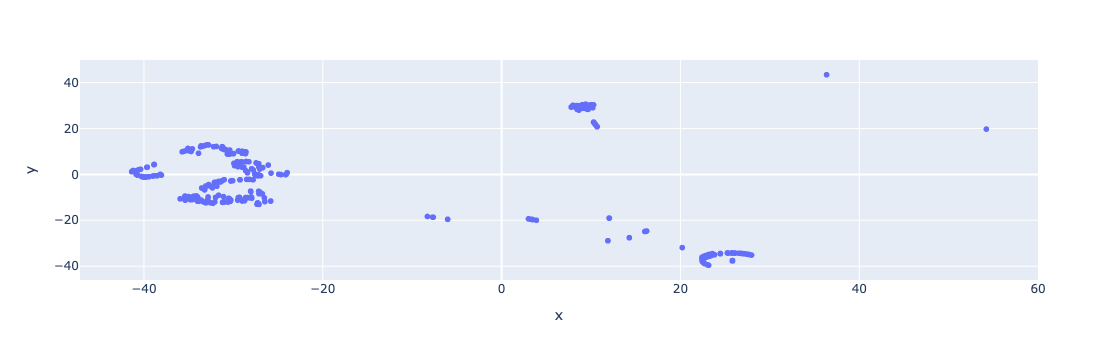

In [19]:
fig = px.scatter(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hover_data=[range(len(images))])
fig.show()

In [20]:
# from jupyter_dash import JupyterDash
from dash import Dash, dcc
from dash import dcc, html, Input, Output, no_update
import plotly.graph_objects as go
from PIL import Image
from io import BytesIO
import base64

In [21]:
# Convert NumPy arrays to base64 encoded strings for HTML embedding
embeddings = reduced_embeddings
def numpy_array_to_base64(img_array):
    if img_array.shape[0] == 3: 
        img_array = img_array.transpose(1, 2, 0)  # Change to channel-last format (height, width, channels)
    # Ensure data type is uint8
    if img_array.dtype != np.uint8:
        img_array = np.clip(img_array*255, 0, 255).astype(np.uint8)
    # print(img_array.shape)
    img_array = img_array[:, :, ::-1] # BGR to RGB
    pil_img = Image.fromarray(img_array)
    buff = BytesIO()
    pil_img.save(buff, format="JPEG")
    return base64.b64encode(buff.getvalue()).decode("utf-8")

print(images[0].shape)
base64_images = [numpy_array_to_base64(img) for img in images]

# Create a DataFrame
df = pd.DataFrame(embeddings, columns=['TSNE1', 'TSNE2'])
df['Image'] = base64_images

(331, 179, 3)


In [22]:

fig = go.Figure(data=[
    go.Scatter(
        x=df["TSNE1"],
        y=df["TSNE2"],
        mode="markers",
        marker=dict(
            color='LightSkyBlue',
            size=5,
            line=dict(
                color='DarkSlateGrey',
                width=2
            )
        )
    )
])
fig.update_traces(hoverinfo="none", hovertemplate=None)

fig.update_layout(
    title={
        'text': "FaceID TSNE TBBT",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis=dict(title='TSNE Dimension 1'),
    yaxis=dict(title='TSNE Dimension 2'),
    plot_bgcolor='rgba(255,255,255,0.1)'
)

app = Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id="graph", figure=fig, clear_on_unhover=True),
    dcc.Tooltip(id="graph-tooltip"),
])

@app.callback(
    Output("graph-tooltip", "show"),
    Output("graph-tooltip", "bbox"),
    Output("graph-tooltip", "children"),
    Input("graph", "hoverData"),
)
def display_hover(hoverData):
    if hoverData is None:
        return False, no_update, no_update

    pt = hoverData["points"][0]
    bbox = pt["bbox"]
    num = pt["pointNumber"]

    df_row = df.iloc[num]
    img_base64 = df_row['Image']
    img_html = f"data:image/jpeg;base64,{img_base64}"

    children = [
        html.Div(children=[
            html.Img(src=img_html, style={"width": "100%", "height": "auto"}),
        ], style={'width': '200px', 'white-space': 'normal'})
    ]

    return True, bbox, children

if __name__ == "__main__":
    # app.run_server(debug=True, mode='external')
    app.run_server(mode='inline', port=8081) 
    # neerja note: need to `ssh -L 8081:localhost:8081 neerja@em12.ist.berkeley.edu` to get this to display